In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, pickle, os
from glob import glob
from tqdm.auto import tqdm
%matplotlib inline

import torch
from torch.utils.data import Dataset as _Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn

from IPython.display import display, display_markdown

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/SIGNATE/JPX_NLP/ipynb')
headline_features = pd.read_pickle('../data/headline_features.pkl')
new_headline_features = pd.read_pickle('../data/new_headline_features.pkl')
new_headline_features.index = new_headline_features.index.tz_convert(headline_features.index.tz)

# 結合
headline_features = pd.concat([headline_features, new_headline_features], axis=0).copy()

# 確認する。
display(headline_features.head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
publish_datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00+09:00,-0.440823,0.191443,-0.008909,-0.319594,-0.072300,0.466741,-0.274743,0.445048,0.498942,0.032077,-0.116360,-0.210355,-0.540868,0.076760,0.144166,-0.083070,-0.130861,0.406029,-0.880392,-0.016643,-0.401534,-0.174557,-0.507542,-0.156647,-0.470245,-0.002902,-0.077969,0.200966,0.490740,-0.013113,-0.224081,-0.213589,0.298567,-0.771389,-0.276680,-0.109319,0.383235,0.474170,-0.663548,0.357793,...,0.176774,0.044710,-0.414676,0.077046,0.306751,-0.322008,-0.399087,0.032362,0.146632,0.271159,0.388895,-0.259030,-0.350281,-0.461752,0.224659,0.889025,-0.061976,-0.334288,0.316534,0.263425,-0.336472,-0.026560,-0.194603,-0.401397,-0.357503,-0.171333,1.203775,0.135907,-0.219807,0.067140,-0.343381,0.090035,0.199363,-0.338375,0.670792,0.026400,0.632040,-0.433479,-0.011136,-0.051264
2020-01-01 00:00:00+09:00,-0.351773,-0.027478,-0.060213,-0.512602,0.254371,0.128152,0.160517,0.154172,0.151672,0.255984,-0.230775,-0.098318,-0.255182,0.198917,0.091325,0.333755,-0.350224,0.434262,-0.741817,0.054787,-0.253943,-0.163718,-0.461441,0.347626,-0.417080,-0.341026,0.398471,0.524607,0.389910,-0.131546,-0.249743,-0.230001,0.492881,-0.331608,-0.200333,0.241359,0.041618,0.306015,-0.163136,-0.184070,...,0.069858,0.106802,-0.354729,0.134215,0.056386,0.091783,0.157682,-0.054993,-0.383481,0.020656,0.051864,0.027854,-0.321652,-0.419941,0.393403,0.372779,-0.253009,-0.220912,0.261291,0.692285,-0.348436,0.223210,-0.266056,-0.156660,-0.445325,-0.127257,1.229320,0.008953,0.083672,-0.163923,-0.078464,0.179369,0.076657,-0.030442,-0.168868,-0.192623,0.602098,-0.076874,-0.616428,-0.406168
2020-01-01 00:00:00+09:00,-0.115327,0.017725,-0.129011,-0.553259,0.096930,0.092610,0.150430,-0.043717,-0.105239,-0.155988,-0.154242,-0.242510,-0.239033,0.320415,0.191876,0.072502,-0.216562,0.361295,-0.556484,0.129293,-0.193645,-0.299483,-0.316695,0.181502,-0.333302,-0.048888,0.322582,0.114064,0.191149,-0.273356,-0.233236,-0.148562,0.404423,-0.071014,-0.236584,-0.222589,-0.070523,0.314043,0.036919,-0.230962,...,0.115108,0.093348,-0.557689,0.183027,0.121996,-0.053480,-0.108358,0.128004,-0.398424,-0.132420,-0.145719,-0.089708,-0.082902,-0.274402,0.195215,0.368649,-0.419276,-0.068424,-0.111545,0.604652,-0.136284,0.292966,-0.244314,-0.219133,-0.625520,0.238757,1.272057,0.088771,-0.142740,-0.232222,-0.505299,0.315577,0.302115,0.032662,0.129836,-0.134002,0.500410,-0.120089,-0.640578,-0.581745


In [ ]:
# stock_priceとstock_listをロードします。
stock_price = pd.read_csv('../data/stock_price.csv.gz')
new_stock_price = pd.read_csv('../data/new_stock_price_all.csv')
stock_list = pd.read_csv('../data/stock_list.csv.gz')

# 結合する
stock_price = pd.concat([stock_price, new_stock_price], axis=0).copy()
stock_price.sort_values(by=['Local Code', 'EndOfDayQuote Date'], inplace=True)
stock_price.reset_index(drop=True, inplace=True)

# 確認する
display(stock_price.head(3))
display(stock_list.head(3))

,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,Unnamed: 0
0,1301,2016/01/04,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250,NaN
1,1301,2016/01/05,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990,NaN
2,1301,2016/01/06,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867,NaN


,prediction_target,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,universe_comp2
0,True,20201230,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2020/11/06,10928283.0,True
1,True,20201230,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/05,312430277.0,True
2,True,20201230,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/02,52656910.0,True


In [ ]:
# stock_listから投資対象銘柄を取得し、stock_priceの銘柄を絞り込む
codes = stock_list[stock_list["universe_comp2"] == True]["Local Code"].values
stock_price = stock_price.loc[stock_price.loc[:, "Local Code"].isin(codes)]

stock_price = stock_price[['EndOfDayQuote Date', 'Local Code', "EndOfDayQuote Open", "EndOfDayQuote ExchangeOfficialClose"]]

# それぞれのcolumn名をわかりやすく変更する
stock_price = stock_price.rename(columns={
    'EndOfDayQuote Date': 'date',
    'Local Code': 'asset',
    'EndOfDayQuote Open': 'open',
    'EndOfDayQuote ExchangeOfficialClose': 'close',
})

# データごとにindex形式が異なると大変扱いにくい。下記のコードより特徴量と同様のindexの形式を変更する。
# pd.to_datetimeより、string形式の日付をpd.Timestamp形式に変換する
# pd.Timestamp形式をpd.DatetimeIndex形式に変更し、time zoneをheadline_featuresと同様に設定する。
# この際、headline_featuresとkeywords_featuresはarticlesのindexを使用しているため、timezoneが一致している。どちらを用いても良い。
stock_price['date'] = pd.to_datetime(stock_price['date'])
stock_price['date'] = pd.DatetimeIndex(stock_price['date']).tz_localize(headline_features.index.tz)

# indexを['date', 'asset']順のpd.MultiIndex形式として設定する。
stock_price = stock_price.set_index(['date', 'asset']).sort_index()

# unstack()より銘柄情報をcolumnに移動させる。
stock_price = stock_price.unstack()

# 今回使用するデータは2020年以降のデータであるので、2020年以前のデータを切り捨てる。
stock_price = stock_price['2020-01-01':]

# 確認する
display(stock_price.head())

open                 ...   close               
asset                        1301   1332    1333  ...    9991    9994   9997
date                                              ...                       
2020-01-06 00:00:00+09:00  2860.0  639.0  2770.0  ...  1098.0  2271.0  703.0
2020-01-07 00:00:00+09:00  2864.0  634.0  2725.0  ...  1113.0  2296.0  706.0
2020-01-08 00:00:00+09:00  2892.0  624.0  2714.0  ...  1111.0  2307.0  689.0
2020-01-09 00:00:00+09:00  2911.0  628.0  2734.0  ...  1135.0  2308.0  695.0
2020-01-10 00:00:00+09:00  2940.0  627.0  2765.0  ...  1129.0  2280.0  696.0

[5 rows x 3558 columns]

In [ ]:
def _build_weekly_group(df):
    # index情報から、(year, week)の情報を得る。
    return pd.Series(list(zip(df.index.year, df.index.week)), index=df.index)


def build_weekly_features(features, boundary_week):
    assert isinstance(boundary_week, tuple)

    weekly_group = _build_weekly_group(df=features)
    features = features.groupby(weekly_group).apply(lambda x: x[:])

    train_features = features[features.index.get_level_values(0) <= boundary_week]
    test_features = features[features.index.get_level_values(0) > boundary_week]

    return {'train': train_features, 'test': test_features}

def build_weekly_labels(stock_price, boundary_week):
    def _compute_weekly_return(x):
        # その週の初営業日のopenから最終営業日のcloseまでのリターンを計算する。
        weekly_return = ((x['close'].iloc[-1] - x['open'].iloc[0]) / x['open'].iloc[0])

        # その日のvolumneが0であるデータは、openが0となっている。
        # openが0の場合、np.infの値となっているため、np.nanに変換し除去する。
        # 銘柄ごとのリターンを単純平均し、marketのweekly_returnを計算する。
        return weekly_return.replace([np.inf, -np.inf], np.nan).dropna().mean()

    assert isinstance(boundary_week, tuple)

    weekly_group = _build_weekly_group(df=stock_price)
    weekly_fwd_return = stock_price.groupby(weekly_group).apply(_compute_weekly_return).shift(-1).dropna()

    train_labels = weekly_fwd_return[weekly_fwd_return.index <= boundary_week]
    test_labels = weekly_fwd_return[weekly_fwd_return.index > boundary_week]

    train_labels = (train_labels >= 0) * 1.0
    test_labels = (test_labels >= 0) * 1.0

    return {'train': train_labels, 'test': test_labels}

## Pytorch Dataset作成

今回、学習に用いる週次のデータセットにおいて、LSTMの学習には週毎のニュースの件数が若干不足している傾向にあることから、過学習防止のため、少し工夫をしています。具体的には、全体的な特徴量(ニュースの情報)の順序は維持しつつ複数に分割し、その分割の中でシャッフルを行う方法を取ります。この方法を用いることで、モデルに入力するデータを増やすことでき、過学習を防止に繋がる効果が期待できます。

In [ ]:
#上記のコードをまとめて、pytorchのDatasetクラスを作成する

class Dataset(_Dataset):
    def __init__(self, weekly_features, weekly_labels, max_sequence_length):
        # 共通する週のみを使うため、共通するindex情報を取得する
        mask_index = (
            weekly_features.index.get_level_values(0).unique() & weekly_labels.index
        )

        # 共通するindexのみのデータだけでreindexを行う。
        self.weekly_features = weekly_features[
            weekly_features.index.get_level_values(0).isin(mask_index)
        ]
        self.weekly_labels = weekly_labels.reindex(mask_index)

        # idからweekの情報を取得できるよう、id_to_weekをビルドする
        self.id_to_week = {
            id: week for id, week in enumerate(sorted(weekly_labels.index))
        }

        self.max_sequence_length = max_sequence_length

    def _shuffle_by_local_split(self, x, split_size=50):
        return torch.cat(
            [
                splitted[torch.randperm(splitted.size()[0])]
                for splitted in x.split(split_size, dim=0)
            ],
            dim=0,
        )

    def __len__(self):
        return len(self.weekly_labels)

    def __getitem__(self, id):
        # 付与されたidから週の情報を取得し、その週の情報から、特徴量とラベルを取得する。
        week = self.id_to_week[id]
        x = self.weekly_features.xs(week, axis=0, level=0)[-self.max_sequence_length :]
        y = self.weekly_labels[week]

        # pytorchでは、データをtorch.Tensorタイプとして扱うことが要求される。
        # 全体的な特徴量(ニュースの情報)の順序は維持しつつ、入力とする特徴量を数分割し、その分割の中でシャッフルを行う。
        x = self._shuffle_by_local_split(torch.tensor(x.values, dtype=torch.float))
        y = torch.tensor(y, dtype=torch.float)

        # max_sequence_lengthに最大のsequenceを合わせ、sequenceがmax_sequence_lengthに達しない場合は、前から0を埋め、sequenceを合わせる
        if x.size()[0] < self.max_sequence_length:
            x = F.pad(x, pad=(0, 0, self.max_sequence_length - x.size()[0], 0))

        return x, y

## LSTMによる特徴量合成モデル

In [ ]:
class FeatureCombiner(nn.Module):
    def __init__(self, input_size, hidden_size, compress_dim=4, num_layers=2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTMの定義
        # batch_firstより、出力次元の最初がbatchとなる。
        # dropoutを用いて、内部状態のconnectionをdropすることより過学習を防ぐ。
        # Sequenceがかなり長く、入力の始めの方の情報の消失を防ぐため、bidirectionalのモデルを使う。
        self.cell = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.5,
            bidirectional=True,
        )

        # より高次元の特徴量を抽出できるようにするため、classifierの手前で、compress_dim次元への線形圧縮を行う。
        self.compressor = nn.Linear(hidden_size * 2, compress_dim)

        # sentiment probabilityの出力層。
        self.classifier = nn.Linear(compress_dim, 1)

        # outputの範囲を[0, 1]とする。
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 入力値xから出力までの流れを定義する。
        output, _ = self.cell(x)
        output = self.sigmoid(self.classifier(self.compressor(output[:, -1, :])))
        return output

    def extract_feature(self, x):
        # 入力値xから特徴量抽出までの流れを定義する。
        output, _ = self.cell(x)
        output = self.compressor(output[:, -1, :])
        return output

In [ ]:
class FeatureCombinerHandler:
    def __init__(self, feature_combiner_params, store_dir):
        # モデル学習及び推論に用いるデバイスを定義する
        if torch.cuda.device_count() >= 1:
            self.device = 'cuda'
            print("[+] Set Device: GPU")
        else:
            self.device = 'cpu'
            print("[+] Set Device: CPU")

        # モデルのcheckpointや抽出した特徴量及びsentimentをstoreする場所を定義する。
        self.store_dir = store_dir
        os.makedirs(store_dir, exist_ok=True)

        # 上記で作成したfeaturecombinerを定義する。
        self.feature_combiner = FeatureCombiner(**feature_combiner_params).to(
            self.device
        )

        # 学習に用いるoptimizerを定義する。
        self.optimizer = torch.optim.Adam(
            params=self.feature_combiner.parameters(), lr=0.001,
        )

        # ロス関数の定義
        self.criterion = nn.BCELoss().to(self.device)

        # モデルのcheck pointが存在する場合、モデルをロードする
        self._load_model()

    # 学習に必要なデータ(並列のためbatch化されたもの)をサンプルする。
    def _sample_xy(self, data_type):
        assert data_type in ("train", "val")

        # data_typeより、data_typeに合致したデータを取得するようにしている。
        if data_type == "train":
            # dataloaderをiteratorとして定義し、next関数として毎時のデータをサンプルすることができる。
            # Iteratorは全てのデータがサンプルされると、StopIterationのエラーを発するが、そのようなエラーが出たとき、
            # Iteratorを再定義し、データをサンプルするようにしている。
            try:
                x, y = next(self.iterable_train_dataloader)
            except StopIteration:
                self.iterable_train_dataloader = iter(self.train_dataloader)
                x, y = next(self.iterable_train_dataloader)

        elif data_type == "val":
            try:
                x, y = next(self.iterable_val_dataloader)
            except StopIteration:
                self.iterable_val_dataloader = iter(self.val_dataloader)
                x, y = next(self.iterable_val_dataloader)

        return x.to(self.device), y.to(self.device)

    # モデルのパラメータをアップデートするロジック
    def _update_params(self, loss):
        # ロスから、gradientを逆伝播し、パラメータをアップデートする
        loss.backward()
        self.optimizer.step()

    # 学習されたfeature_combinerのパラメータをcheck_pointとしてstoreするロジック
    def _save_model(self, epoch):
        torch.save(
            self.feature_combiner.state_dict(),
            os.path.join(self.store_dir, f"{epoch}.ckpt"),
        )
        print(f"[+] Epoch: {epoch}, Model is saved.")

    # 学習されたcheckpointが存在す場合、feature_combinerにそのパラメータをロードするロジック
    def _load_model(self):
        # cudaで学習されたモデルなどを、cpu環境下でロードするときはこのパラメータが必要となる。
        params_to_load = {}
        if self.device == "cpu":
            params_to_load["map_location"] = torch.device("cpu")

        # .ckptファイルを探し、古い順から新しい順にソートする。
        check_points = glob(os.path.join(self.store_dir, "*.ckpt"))
        check_points = sorted(
            check_points, key=lambda x: int(x.split("/")[-1].replace(".ckpt", "")),
        )

        # check_pointが存在しない場合は、スキップする。
        if len(check_points) == 0:
            print("[!] No exists checkpoint")
            return

        # 複数個のchieck_pointが存在する場合、一番最新のものを使い、モデルのパラメータをロードする
        check_point = check_points[-1]
        self.feature_combiner.load_state_dict(torch.load(check_point, **params_to_load))
        print("[+] Model is loaded")

    # Datasetからdataloaderを定義するロジック
    def _build_dataloader(
        self, dataloader_params, weekly_features, weekly_labels, max_sequence_length
    ):
        # 上記3で作成したしたdatasetを定義する
        dataset = Dataset(
            weekly_features=weekly_features,
            weekly_labels=weekly_labels,
            max_sequence_length=max_sequence_length,
        )

        # datasetのdataをiterableにロードできるよう、dataloaderを定義する、このとき、shuffle=Trueを渡すことで、データはランダムにサンプルされるようになる。
        return DataLoader(dataset=dataset, shuffle=True, **dataloader_params)

    # train用に、featuresとlabelsを渡し、datasetを定義し、dataloaderを定義するロジック
    def set_train_dataloader(
        self, dataloader_params, weekly_features, weekly_labels, max_sequence_length
    ):
        self.train_dataloader = self._build_dataloader(
            dataloader_params=dataloader_params,
            weekly_features=weekly_features,
            weekly_labels=weekly_labels,
            max_sequence_length=max_sequence_length,
        )

        # dataloaderからiteratorを定義する
        # iteratorはnext関数よりデータをサンプルすることが可能となる。
        self.iterable_train_dataloader = iter(self.train_dataloader)

    # validation用に、featuresとlabelsを渡し、datasetを定義し、dataloaderを定義するロジック
    def set_val_dataloader(
        self, dataloader_params, weekly_features, weekly_labels, max_sequence_length
    ):
        self.val_dataloader = self._build_dataloader(
            dataloader_params=dataloader_params,
            weekly_features=weekly_features,
            weekly_labels=weekly_labels,
            max_sequence_length=max_sequence_length,
        )

        # dataloaderからiteratorを定義する
        # iteratorはnext関数よりデータをサンプルすることが可能となる。
        self.iterable_val_dataloader = iter(self.val_dataloader)

    # 学習ロジック
    def train(self, n_epoch):
        best_loss = 1

        # n_epochの回数分、全学習データを複数回用いて学習する。
        for epoch in range(n_epoch):

            # 各々のepochごとのaverage lossを表示するため、lossをstoreするリストを定義する。
            train_losses = []
            test_losses = []

            # train_dataloaderの長さは、全ての学習データを一度用いるときの長さと同様である。
            # batchを組むと、その分train_dataloaderの長さは可変し、ちょうど一度全てのデータで学習できる長さを返す。
            for iter_ in tqdm(range(len(self.train_dataloader))):
                # パラメータをtrainableにするため、feature_combinerをtrainモードにする。
                self.feature_combiner.train()

                # trainデータをサンプルする。
                x, y = self._sample_xy(data_type="train")

                # feature_combinerに特徴量を入力し、sentiment scoreを取得する。
                preds = self.feature_combiner(x=x)

                # sentiment scoreとラベルとのロスを計算する。
                train_loss = self.criterion(preds, y.view(-1, 1))

                # 計算されたロスは、後ほどepochごとのdisplayに使用するため、storeしておく。
                train_losses.append(train_loss.detach().cpu())

                # lossから、gradientを逆伝播させ、パラメータをupdateする。
                self._update_params(loss=train_loss)

                # validation用のロースを計算する。
                # 毎回計算を行うとコストがかかってくるので、iter_毎5回ごとに計算を行う。
                if iter_ % 5 == 0:

                    # 学習を行わないため、feature_combinerをevalモードにしておく。
                    # evalモードでは、dropoutの影響を受けない。
                    self.feature_combiner.eval()

                    # 各パラメータごとのgradientを計算するとリソースが高まる。
                    # evaluationの時には、gradient情報を持たせないことで、メモリーの節約に繋がる。
                    with torch.no_grad():
                        # validationデータをサンプルする
                        x, y = self._sample_xy(data_type="val")

                        # feature_combinerに特徴量を入力し、sentiment scoreを取得する。
                        preds = self.feature_combiner(x=x)

                        # sentiment scoreとラベルとのロスを計算する。
                        test_loss = self.criterion(preds, y.view(-1, 1))

                        # 計算されたロスは、後ほどepochごとのdisplayに使用するため、storeしておく。
                        test_losses.append(test_loss.detach().cpu())

            # 毎epoch終了後、平均のロスをプリントする。
            print(
                f"epoch: {epoch}, train_loss: {np.mean(train_losses):.4f}, val_loss: {np.mean(test_losses):.4f}"
            )

            # 毎epoch終了後、モデルのパラメータをstoreする。
            if np.mean(train_losses) < best_loss:
              self._save_model(epoch=epoch)
              best_loss = np.mean(train_losses)

    # 特徴量から、合成特徴量を抽出するロジック
    def combine_features(self, features):
        # 学習を行わないため、feature_combinerをevalモードにしておく。
        self.feature_combiner.eval()

        # gradient情報を持たせないことで、メモリーの節約する。
        with torch.no_grad():

            # 特徴量をfeature_combinerのextract_feature関数に入力し、出力層手前の特徴量を抽出する。
            # 抽出するとき、tensorをcpu上に落とし、np.ndarray形式に変換する。
            return (
                self.feature_combiner.extract_feature(
                    x=torch.tensor(features, dtype=torch.float).to(self.device)
                )
                .cpu()
                .numpy()
            )

    # 特徴量から、翌週のsentimentを予測するロジック
    def predict_sentiment(self, features):
        # 学習を行わないため、feature_combinerをevalモードにしておく。
        self.feature_combiner.eval()

        # gradient情報を持たせないことで、メモリーの節約する。
        with torch.no_grad():

            # 特徴量をfeature_combinerに入力し、sentiment scoreを抽出する。
            # 抽出するとき、tensorをcpu上に落とし、np.ndarray形式に変換する。
            return (
                self.feature_combiner(x=torch.tensor(features, dtype=torch.float).to(self.device))
                .cpu()
                .numpy()
            )

    # weeklyグループされた特徴量を入力に、合成特徴量もしくは、sentiment scoreを抽出するロジック
    def generate_by_weekly_features(
        self, weekly_features, generate_target, max_sequence_length
    ):
        assert generate_target in ("features", "sentiment")
        generate_func = getattr(
            self,
            {"features": "combine_features", "sentiment": "predict_sentiment"}[
                generate_target
            ],
        )

        # グループごとに特徴量もしくは、sentiment scoreを抽出し、最終的に重ねて返すため、リストを作成する。
        outputs = []

        # ユニークな週indexを取得する。
        weeks = sorted(weekly_features.index.get_level_values(0).unique())

        for week in tqdm(weeks):
            # 各週ごとの特徴量を取得し、直近から、max_sequence_length分切る。
            features = weekly_features.xs(week, axis=0, level=0)[-max_sequence_length:]

            # 特徴量をモデルに入力し、合成特徴量もしくは、sentiment scoreを抽出し、outputsにappendする。
            # np.expand_dims(features, axis=0)を用いる理由は、特徴量合成機の入力期待値は、dimention0がbatchであるが、
            # featuresは、[1000, 768]の次元をもち、これらをunsqueezeし、[1, 1000, 768]に変換する必要がある。
            outputs.append(generate_func(features=np.expand_dims(features, axis=0)))

        # outputsを重ね、indexの情報とともにpd.DataFrame形式として返す。
        return pd.DataFrame(np.concatenate(outputs, axis=0), index=weeks)

## 特徴量合成モデルの学習及び特徴量合成

In [ ]:
features = headline_features

feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir='./test')
boundary_week = (2020, 53)
weekly_features = build_weekly_features(features, boundary_week)
weekly_labels = build_weekly_labels(stock_price, boundary_week)

[+] Set Device: GPU
[!] No exists checkpoint


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# train dataloaderをsetする。
feature_combiner_handler.set_train_dataloader(
    dataloader_params={
        "batch_size": 4,
        "num_workers": 2,
    },
    weekly_features=weekly_features['train'],
    weekly_labels=weekly_labels['train'],
    max_sequence_length=1000
)

# validation dataloaderをsetする。
feature_combiner_handler.set_val_dataloader(
    dataloader_params={
        "batch_size": 4,
        "num_workers": 2,
    },
    weekly_features=weekly_features['test'],
    weekly_labels=weekly_labels['test'],
    max_sequence_length=1000
)

In [ ]:
feature_combiner_handler.train(n_epoch=30)


epoch: 0, train_loss: 0.7273, val_loss: 0.6638
[+] Epoch: 0, Model is saved.



epoch: 1, train_loss: 0.6842, val_loss: 0.7648
[+] Epoch: 1, Model is saved.



epoch: 2, train_loss: 0.6955, val_loss: 0.7694



epoch: 3, train_loss: 0.6949, val_loss: 0.7348



epoch: 4, train_loss: 0.7013, val_loss: 0.6858



epoch: 5, train_loss: 0.6969, val_loss: 0.7255



epoch: 6, train_loss: 0.7178, val_loss: 0.9718



epoch: 7, train_loss: 0.7134, val_loss: 0.6566



epoch: 8, train_loss: 0.6938, val_loss: 0.6708



epoch: 9, train_loss: 0.6951, val_loss: 0.6870



epoch: 10, train_loss: 0.7067, val_loss: 0.6977



epoch: 11, train_loss: 0.7052, val_loss: 0.6441



epoch: 12, train_loss: 0.7022, val_loss: 0.6834



epoch: 13, train_loss: 0.7019, val_loss: 0.7108



epoch: 14, train_loss: 0.6965, val_loss: 0.6974



epoch: 15, train_loss: 0.6953, val_loss: 0.6931



epoch: 16, train_loss: 0.6936, val_loss: 0.6926



epoch: 17, train_loss: 0.6927, val_loss: 0.6925



epoch: 18, train_loss: 0.6920, val_loss: 0.6933



epoch: 19, train_loss: 0.6923, val_loss: 0.6976



epoch: 20, train_loss: 0.6905, val_loss: 0.6947



epoch: 21, train_loss: 0.6903, val_loss: 0.6886



epoch: 22, train_loss: 0.6901, val_loss: 0.7152



epoch: 23, train_loss: 0.6872, val_loss: 0.6993



epoch: 24, train_loss: 0.6790, val_loss: 0.6964
[+] Epoch: 24, Model is saved.



epoch: 25, train_loss: 0.6817, val_loss: 0.7680



epoch: 26, train_loss: 0.6756, val_loss: 0.7570
[+] Epoch: 26, Model is saved.



epoch: 27, train_loss: 0.7060, val_loss: 0.8166



epoch: 28, train_loss: 0.7184, val_loss: 0.7395



epoch: 29, train_loss: 0.7236, val_loss: 0.9557


In [ ]:
# 特徴量及びsentiment scoreを抽出し、pickleとしてstoreする。
feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='sentiment', max_sequence_length=10000).to_pickle('./test/LSTM_sentiment.pkl')
feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='features', max_sequence_length=10000).to_pickle('./test/LSTM_features.pkl')

In [ ]:
feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir='./test')
headline_features = pd.read_pickle('./test/LSTM_sentiment.pkl')[0].rename('features')
display(headline_features.head())

[+] Set Device: GPU
[+] Model is loaded


(2021, 1)    0.640614
(2021, 2)    0.642025
(2021, 3)    0.636711
(2021, 4)    0.643563
(2021, 5)    0.631360
Name: features, dtype: float32

In [ ]:
def _compute_weekly_return(x):
        # その週の初営業日のopenから最終営業日のcloseまでのリターンを計算する。
        weekly_return = ((x['close'].iloc[-1] - x['open'].iloc[0]) / x['open'].iloc[0])

        # その日のvolumneが0であるデータは、openが0となっている。
        # openが0の場合、np.infの値となっているため、np.nanに変換し除去する。
        # 銘柄ごとのリターンを単純平均し、marketのweekly_returnを計算する。
        return weekly_return.replace([np.inf, -np.inf], np.nan).dropna().mean()

# boundary_weekを学習時境界と同様に設定し、weekly_fwd_returnsをビルドする。
weekly_group = _build_weekly_group(df=stock_price)
weekly_returns = stock_price.groupby(weekly_group).apply(_compute_weekly_return)
weekly_fwd_returns = weekly_returns.shift(-1).rename('weekly_fwd_returns')

# 特徴量の期間と同様の期間のデータのみを使用する。
weekly_fwd_returns = weekly_fwd_returns.reindex(headline_features.index)

display(weekly_fwd_returns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


(2021, 1)    -0.003879
(2021, 2)     0.009647
(2021, 3)    -0.017199
(2021, 4)     0.045221
(2021, 5)     0.010094
(2021, 6)    -0.021689
(2021, 7)    -0.030629
(2021, 8)     0.007006
(2021, 9)     0.022357
(2021, 10)    0.037725
(2021, 11)   -0.010572
(2021, 12)   -0.021518
(2021, 13)   -0.009209
(2021, 53)         NaN
Name: weekly_fwd_returns, dtype: float64

In [ ]:
# 二つのpd.Seriesをconcatenateする。
# indexの違いがあるため、片方だけ存在するデータはドロップする。
df = pd.concat([headline_features, weekly_fwd_returns], axis=1, sort=True).dropna()

# 二つのコラムのシークエンス間の相関は、以下のように取得できる。
display(df.corr()[df.columns[0]][df.columns[-1]])

0.3941145720085132

In [ ]:
df

,features,weekly_fwd_returns
"(2021, 1)",0.640614,-0.003879
"(2021, 2)",0.642025,0.009647
"(2021, 3)",0.636711,-0.017199
"(2021, 4)",0.643563,0.045221
"(2021, 5)",0.631360,0.010094
"(2021, 6)",0.640157,-0.021689
"(2021, 7)",0.631036,-0.030629
"(2021, 8)",0.631506,0.007006
"(2021, 9)",0.644327,0.022357
"(2021, 10)",0.639795,0.037725


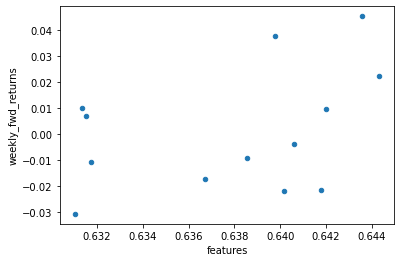

In [ ]:
df.plot.scatter('features', 'weekly_fwd_returns')

###  学習データと検証データの割合を変更してみる(1:1くらいの割合)

[+] Set Device: GPU
[!] No exists checkpoint


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until



epoch: 0, train_loss: 0.7114, val_loss: 0.7049
[+] Epoch: 0, Model is saved.



epoch: 1, train_loss: 0.6852, val_loss: 0.7832
[+] Epoch: 1, Model is saved.



epoch: 2, train_loss: 0.7013, val_loss: 0.7007



epoch: 3, train_loss: 0.7020, val_loss: 0.6464



epoch: 4, train_loss: 0.6870, val_loss: 0.6052



epoch: 5, train_loss: 0.6737, val_loss: 0.7158
[+] Epoch: 5, Model is saved.



epoch: 6, train_loss: 0.6955, val_loss: 0.7474



epoch: 7, train_loss: 0.6679, val_loss: 0.6274
[+] Epoch: 7, Model is saved.



epoch: 8, train_loss: 0.6709, val_loss: 0.7149



epoch: 9, train_loss: 0.7166, val_loss: 0.7621



epoch: 10, train_loss: 0.7024, val_loss: 0.6720



epoch: 11, train_loss: 0.7141, val_loss: 0.7300



epoch: 12, train_loss: 0.7178, val_loss: 0.6448



epoch: 13, train_loss: 0.6880, val_loss: 0.7556



epoch: 14, train_loss: 0.6898, val_loss: 0.6593



epoch: 15, train_loss: 0.6950, val_loss: 0.8194



epoch: 16, train_loss: 0.6899, val_loss: 0.6291



epoch: 17, train_loss: 0.7000, val_loss: 0.7089



epoch: 18, train_loss: 0.6857, val_loss: 0.6991



epoch: 19, train_loss: 0.6916, val_loss: 0.7115



epoch: 20, train_loss: 0.6917, val_loss: 0.6854



epoch: 21, train_loss: 0.6903, val_loss: 0.6830



epoch: 22, train_loss: 0.6950, val_loss: 0.7066



epoch: 23, train_loss: 0.6818, val_loss: 0.7014



epoch: 24, train_loss: 0.6820, val_loss: 0.6715



epoch: 25, train_loss: 0.6803, val_loss: 0.6615



epoch: 26, train_loss: 0.6946, val_loss: 0.7739



epoch: 27, train_loss: 0.7122, val_loss: 0.7438



epoch: 28, train_loss: 0.6864, val_loss: 0.8101



epoch: 29, train_loss: 0.6979, val_loss: 0.6801



[+] Set Device: GPU
[+] Model is loaded


(2020, 36)    0.531508
(2020, 37)    0.512556
(2020, 38)    0.521928
(2020, 39)    0.531684
(2020, 40)    0.512887
Name: features, dtype: float32

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


0.25270635840064937

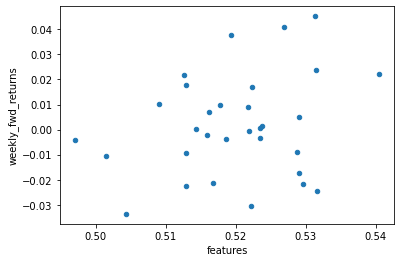

In [ ]:
headline_features = pd.read_pickle('../data/headline_features.pkl')
new_headline_features = pd.read_pickle('../data/new_headline_features.pkl')
new_headline_features.index = new_headline_features.index.tz_convert(headline_features.index.tz)

# 結合
headline_features = pd.concat([headline_features, new_headline_features], axis=0).copy()
features = headline_features

feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir='./test2')
boundary_week = (2020, 35)
weekly_features = build_weekly_features(features, boundary_week)
weekly_labels = build_weekly_labels(stock_price, boundary_week)

# train dataloaderをsetする。
feature_combiner_handler.set_train_dataloader(
    dataloader_params={
        "batch_size": 4,
        "num_workers": 2,
    },
    weekly_features=weekly_features['train'],
    weekly_labels=weekly_labels['train'],
    max_sequence_length=1000
)

# validation dataloaderをsetする。
feature_combiner_handler.set_val_dataloader(
    dataloader_params={
        "batch_size": 4,
        "num_workers": 2,
    },
    weekly_features=weekly_features['test'],
    weekly_labels=weekly_labels['test'],
    max_sequence_length=1000
)

feature_combiner_handler.train(n_epoch=30)

# 特徴量及びsentiment scoreを抽出し、pickleとしてstoreする。
feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='sentiment', max_sequence_length=10000).to_pickle('./test2/LSTM_sentiment.pkl')
feature_combiner_handler.generate_by_weekly_features(weekly_features=weekly_features['test'], generate_target='features', max_sequence_length=10000).to_pickle('./test2/LSTM_features.pkl')

feature_combiner_handler = FeatureCombinerHandler(feature_combiner_params={"input_size": 768, "hidden_size": 128}, store_dir='./test2')
headline_features = pd.read_pickle('./test2/LSTM_sentiment.pkl')[0].rename('features')
display(headline_features.head())

# boundary_weekを学習時境界と同様に設定し、weekly_fwd_returnsをビルドする。
weekly_group = _build_weekly_group(df=stock_price)
weekly_returns = stock_price.groupby(weekly_group).apply(_compute_weekly_return)
weekly_fwd_returns = weekly_returns.shift(-1).rename('weekly_fwd_returns')

# 特徴量の期間と同様の期間のデータのみを使用する。
weekly_fwd_returns = weekly_fwd_returns.reindex(headline_features.index)

# 二つのpd.Seriesをconcatenateする。
# indexの違いがあるため、片方だけ存在するデータはドロップする。
df = pd.concat([headline_features, weekly_fwd_returns], axis=1, sort=True).dropna()

# 二つのコラムのシークエンス間の相関は、以下のように取得できる。
display(df.corr()[df.columns[0]][df.columns[-1]])

df.plot.scatter('features', 'weekly_fwd_returns')